In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from keras import backend as K 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

In [2]:
data = pd.read_csv('/notebooks/tatarstan_message_2.csv', sep = ',')
print(data.columns)
data = data[['categories', 'description_stem']]
data.head(3)

Index(['level_0', 'index', 'categories', 'description', 'worker',
       'description_prep', 'num_words', 'description_stem'],
      dtype='object')


,categories,description_stem
0,Благоустройство территории,трасса нижнекамск чистополь лесополоса пгт кам...
1,Благоустройство территории,двор дом ленинградский отсутствовать парковочн...
2,Содержание и ремонт муниципальных дорог,добрый день осуществляться уборка снег центр г...


In [3]:
data = data.dropna()
text_train = data['description_stem'].to_list()

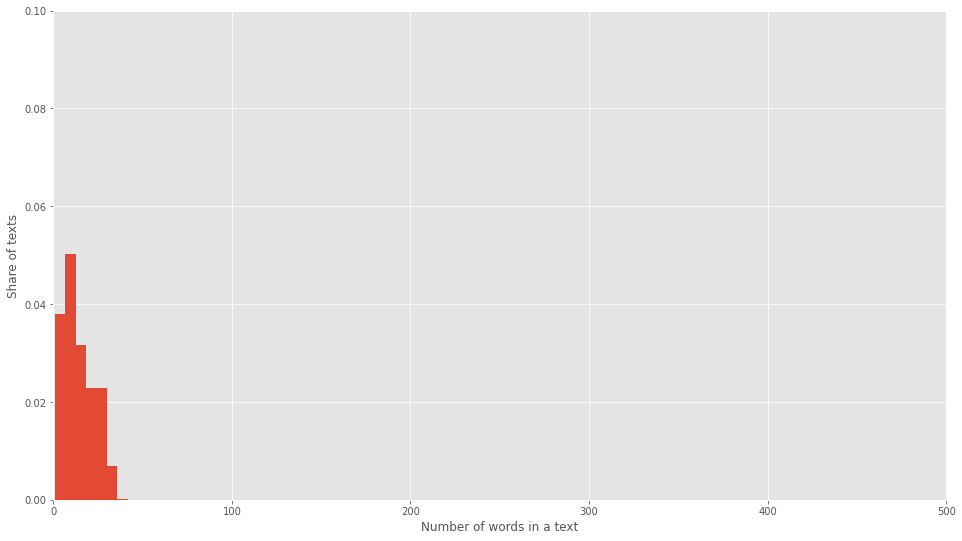

In [4]:
#гистограмма наиболее часто встречающегося количества слов
plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = data['description_stem'].apply(lambda x: len(x.split(' ')))
n, bins, patches = plt.hist(len_of_sent, 500, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 500, 0, 0.1])
plt.grid(True)
plt.show()

#выбираем количество анализируемых слов = 30

In [5]:
#загрузка модели Word2Vec
model = Word2Vec.load("/notebooks/w2v_model/tweets_model.w2v")
model.delete_temporary_training_data()

In [6]:
#загрузка эмбеддингов из словаря модели
e_matrix = []
mydict = []
for word in model.wv.vocab.keys():
    try:
        e_matrix.append(model.wv[word])
        mydict.append(word)
        if len(e_matrix) >= 600000:
            break
    except:
        print("Пропущено слово при заполнении модели")
        continue

print(f"Размерность словаря для embedding {len(e_matrix)}")

NUM = len(e_matrix)
e_matrix = np.array(e_matrix, dtype=object)

Размерность словаря для embedding 600000


In [7]:
DIM = model.vector_size
print(DIM)
print(NUM)
tokenizer = Tokenizer(oov_token = True) #num_words = NUM
tokenizer.fit_on_texts(mydict)

SENTENCE_LENGTH = 30

print("подготовка обучающего набора")
raw_data = [row.split(' ') for row in data['description_stem']]
X = tokenizer.texts_to_sequences(raw_data) 
X = pad_sequences(X, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X[0])}")
print(X.shape)
print(X)

Y = pd.get_dummies(data['categories'])
label_columns=Y.columns #To get the classes
Y = Y.to_numpy() #Convert labels to numpy array
print(Y.shape)
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

200
600000
подготовка обучающего набора
Количество слов в предложении: 30
(23670, 30)
[[    0     0     0 ... 44432 30966 81127]
 [    0     0 16953 ...  5839  5959   594]
 [    0     0     0 ... 81127  2522 84833]
 ...
 [    0     0     0 ... 19103  2997 53564]
 [    0     0     0 ... 39383 35712   373]
 [65932    67     1 ... 23944     1  9070]]
(23670, 26)
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [8]:
# Метрики 
from sklearn.metrics import matthews_corrcoef
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [9]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout, LSTM
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

SENTENCE_LENGTH = 30
NUM = 600000
DIM = 200

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[e_matrix], trainable=False)(tweet_input)
layer = LSTM(64)(tweet_encoder)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(26,name='out_layer')(layer)
layer = Activation('softmax')(layer)
model = Model(tweet_input,outputs=layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 200)           120000000 
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 26)                6682  

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("lstm_weights/CNN_Word2Vec_600000-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.2, callbacks = [checkpoint])

Epoch 1/200
474/474 [==============================] - 8s 9ms/step - loss: 0.1702 - accuracy: 0.4195 - precision: 0.4158 - recall: 0.2854 - f1: 0.3311 - val_loss: 0.0783 - val_accuracy: 0.5953 - val_precision: 0.6138 - val_recall: 0.5675 - val_f1: 0.5893
Epoch 2/200
474/474 [==============================] - 4s 7ms/step - loss: 0.0779 - accuracy: 0.6200 - precision: 0.6548 - recall: 0.5761 - f1: 0.6119 - val_loss: 0.0661 - val_accuracy: 0.6703 - val_precision: 0.7075 - val_recall: 0.6400 - val_f1: 0.6714
Epoch 3/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0644 - accuracy: 0.6858 - precision: 0.7322 - recall: 0.6439 - f1: 0.6844 - val_loss: 0.0610 - val_accuracy: 0.6990 - val_precision: 0.7178 - val_recall: 0.6829 - val_f1: 0.6997
Epoch 4/200
474/474 [==============================] - 4s 7ms/step - loss: 0.0550 - accuracy: 0.7389 - precision: 0.7719 - recall: 0.7080 - f1: 0.7379 - val_loss: 0.0551 - val_accuracy: 0.7310 - val_precision: 0.7585 - val_recall: 0.70

474/474 [==============================] - 4s 8ms/step - loss: 0.0025 - accuracy: 0.9917 - precision: 0.9929 - recall: 0.9917 - f1: 0.9923 - val_loss: 0.1737 - val_accuracy: 0.7173 - val_precision: 0.7209 - val_recall: 0.7148 - val_f1: 0.7178
Epoch 65/200
474/474 [==============================] - 4s 7ms/step - loss: 0.0021 - accuracy: 0.9916 - precision: 0.9922 - recall: 0.9915 - f1: 0.9918 - val_loss: 0.1895 - val_accuracy: 0.7233 - val_precision: 0.7266 - val_recall: 0.7216 - val_f1: 0.7241
Epoch 66/200
474/474 [==============================] - 3s 7ms/step - loss: 0.0025 - accuracy: 0.9919 - precision: 0.9922 - recall: 0.9917 - f1: 0.9920 - val_loss: 0.1897 - val_accuracy: 0.7244 - val_precision: 0.7278 - val_recall: 0.7230 - val_f1: 0.7253
Epoch 67/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0028 - accuracy: 0.9902 - precision: 0.9905 - recall: 0.9900 - f1: 0.9903 - val_loss: 0.1881 - val_accuracy: 0.7249 - val_precision: 0.7293 - val_recall: 0.7239 - val_

Epoch 128/200
474/474 [==============================] - 4s 7ms/step - loss: 0.0015 - accuracy: 0.9945 - precision: 0.9946 - recall: 0.9944 - f1: 0.9945 - val_loss: 0.2527 - val_accuracy: 0.7162 - val_precision: 0.7187 - val_recall: 0.7158 - val_f1: 0.7172
Epoch 129/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0015 - accuracy: 0.9951 - precision: 0.9954 - recall: 0.9948 - f1: 0.9951 - val_loss: 0.2443 - val_accuracy: 0.7112 - val_precision: 0.7143 - val_recall: 0.7108 - val_f1: 0.7125
Epoch 130/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0017 - accuracy: 0.9945 - precision: 0.9947 - recall: 0.9942 - f1: 0.9945 - val_loss: 0.2592 - val_accuracy: 0.7130 - val_precision: 0.7169 - val_recall: 0.7118 - val_f1: 0.7143
Epoch 131/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0013 - accuracy: 0.9961 - precision: 0.9964 - recall: 0.9960 - f1: 0.9962 - val_loss: 0.2595 - val_accuracy: 0.7218 - val_precision: 0.7236 - val_reca

Epoch 160/200
474/474 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.9953 - precision: 0.9954 - recall: 0.9949 - f1: 0.9951 - val_loss: 0.2645 - val_accuracy: 0.7130 - val_precision: 0.7157 - val_recall: 0.7117 - val_f1: 0.7137
Epoch 161/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0012 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - f1: 0.9949 - val_loss: 0.2668 - val_accuracy: 0.7191 - val_precision: 0.7210 - val_recall: 0.7180 - val_f1: 0.7195
Epoch 162/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0015 - accuracy: 0.9947 - precision: 0.9950 - recall: 0.9947 - f1: 0.9948 - val_loss: 0.2615 - val_accuracy: 0.7078 - val_precision: 0.7117 - val_recall: 0.7069 - val_f1: 0.7093
Epoch 163/200
474/474 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.9943 - precision: 0.9945 - recall: 0.9943 - f1: 0.9944 - val_loss: 0.2752 - val_accuracy: 0.7183 - val_precision: 0.7199 - val_reca

Epoch 192/200
474/474 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.9957 - precision: 0.9964 - recall: 0.9957 - f1: 0.9961 - val_loss: 0.2727 - val_accuracy: 0.7223 - val_precision: 0.7249 - val_recall: 0.7221 - val_f1: 0.7235
Epoch 193/200
474/474 [==============================] - 4s 8ms/step - loss: 0.0011 - accuracy: 0.9959 - precision: 0.9962 - recall: 0.9959 - f1: 0.9960 - val_loss: 0.2744 - val_accuracy: 0.7152 - val_precision: 0.7166 - val_recall: 0.7135 - val_f1: 0.7150
Epoch 194/200
474/474 [==============================] - 3s 7ms/step - loss: 0.0022 - accuracy: 0.9947 - precision: 0.9949 - recall: 0.9940 - f1: 0.9944 - val_loss: 0.2583 - val_accuracy: 0.7136 - val_precision: 0.7170 - val_recall: 0.7130 - val_f1: 0.7150
Epoch 195/200
474/474 [==============================] - 4s 7ms/step - loss: 0.0013 - accuracy: 0.9954 - precision: 0.9956 - recall: 0.9952 - f1: 0.9954 - val_loss: 0.2684 - val_accuracy: 0.7130 - val_precision: 0.7152 - val_reca

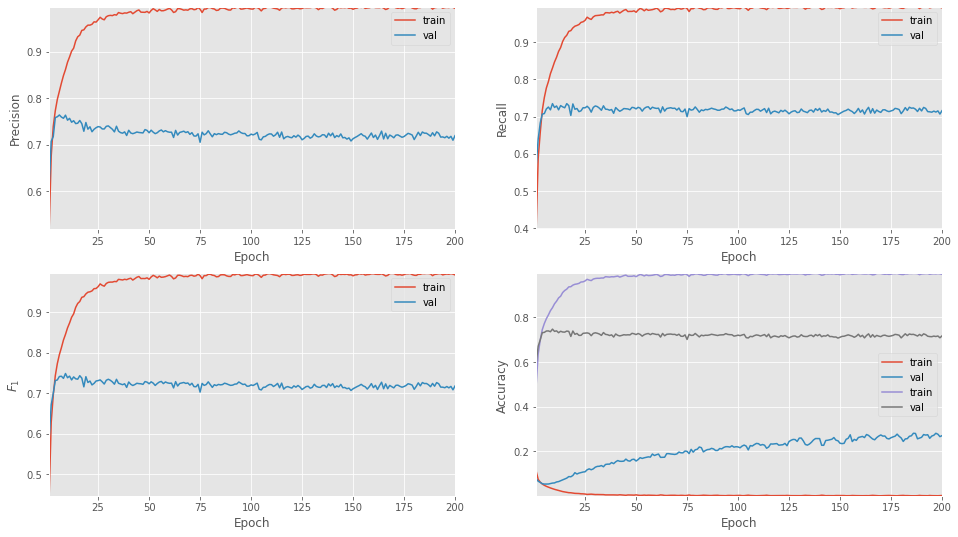

In [11]:
plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [11]:
model.load_weights('lstm_weights/CNN_Word2Vec_600000-09-0.75.hdf5')

In [12]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.array(model.predict(X_test))
predicted = np.argmax(predicted, axis=1)
Y_test = np.array(Y_test)
Y_test_ = np.argmax(Y_test, axis = 1)
print(classification_report(Y_test_, predicted, digits=3))
print(matthews_corrcoef(Y_test_, predicted))

Оценки тестового набора:
              precision    recall  f1-score   support

           0      0.800     0.282     0.417        71
           1      0.839     0.853     0.846       116
           2      0.757     0.811     0.783      2196
           3      0.000     0.000     0.000         4
           4      0.800     0.516     0.627        31
           5      0.400     0.071     0.121        28
           6      0.000     0.000     0.000        14
           7      0.000     0.000     0.000         6
           8      0.667     0.296     0.410        27
           9      0.906     0.763     0.829        38
          10      0.807     0.776     0.791       210
          12      0.700     0.692     0.696       182
          13      0.000     0.000     0.000         2
          14      0.739     0.793     0.765       324
          15      0.444     0.116     0.184        69
          16      0.770     0.777     0.773       112
          17      1.000     0.125     0.222         8
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', precision, recall, f1])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 200)           120000000 
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 26)                6682  

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("lstm_weights/CNN_Word2Vec_LSTM_2-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max')

history_trainable = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_split=0.25, callbacks = [checkpoint])

Epoch 1/20
444/444 [==============================] - 553s 1s/step - loss: 0.0256 - accuracy: 0.8825 - precision: 0.8979 - recall: 0.8730 - f1: 0.8850 - val_loss: 0.0497 - val_accuracy: 0.7765 - val_precision: 0.7929 - val_recall: 0.7661 - val_f1: 0.7791
Epoch 2/20
444/444 [==============================] - 535s 1s/step - loss: 0.0232 - accuracy: 0.8966 - precision: 0.9148 - recall: 0.8865 - f1: 0.9002 - val_loss: 0.0500 - val_accuracy: 0.7807 - val_precision: 0.7966 - val_recall: 0.7714 - val_f1: 0.7836
Epoch 3/20
444/444 [==============================] - 526s 1s/step - loss: 0.0217 - accuracy: 0.9020 - precision: 0.9185 - recall: 0.8932 - f1: 0.9055 - val_loss: 0.0507 - val_accuracy: 0.7860 - val_precision: 0.7980 - val_recall: 0.7761 - val_f1: 0.7867
Epoch 4/20
444/444 [==============================] - 537s 1s/step - loss: 0.0197 - accuracy: 0.9162 - precision: 0.9323 - recall: 0.9064 - f1: 0.9190 - val_loss: 0.0518 - val_accuracy: 0.7879 - val_precision: 0.8003 - val_recall: 0.77

In [10]:
model.load_weights('lstm_weights/CNN_Word2Vec_LSTM_2-14-0.80.hdf5')

In [11]:
plot_history(history_trainable)

NameError: name 'plot_history' is not defined

In [12]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.array(model.predict(X_test))
predicted = np.argmax(predicted, axis=1)
Y_test = np.array(Y_test)
Y_test_ = np.argmax(Y_test, axis = 1)
print(classification_report(Y_test_, predicted, digits=3))
print(matthews_corrcoef(Y_test_, predicted))

Оценки тестового набора:
              precision    recall  f1-score   support

           0      0.660     0.493     0.565        71
           1      0.839     0.897     0.867       116
           2      0.780     0.832     0.805      2196
           3      0.000     0.000     0.000         4
           4      0.857     0.581     0.692        31
           5      0.250     0.071     0.111        28
           6      1.000     0.214     0.353        14
           7      0.000     0.000     0.000         6
           8      0.733     0.407     0.524        27
           9      0.909     0.789     0.845        38
          10      0.857     0.800     0.828       210
          12      0.800     0.769     0.784       182
          13      0.000     0.000     0.000         2
          14      0.774     0.812     0.792       324
          15      0.255     0.174     0.207        69
          16      0.821     0.821     0.821       112
          17      1.000     0.125     0.222         8
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
